In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import investpy
from Indicators import sign_momentum

In [2]:
df=investpy.get_stock_historical_data(stock='ADH', country='morocco', from_date='01/01/2022', to_date='01/07/2022')

In [ ]:
df

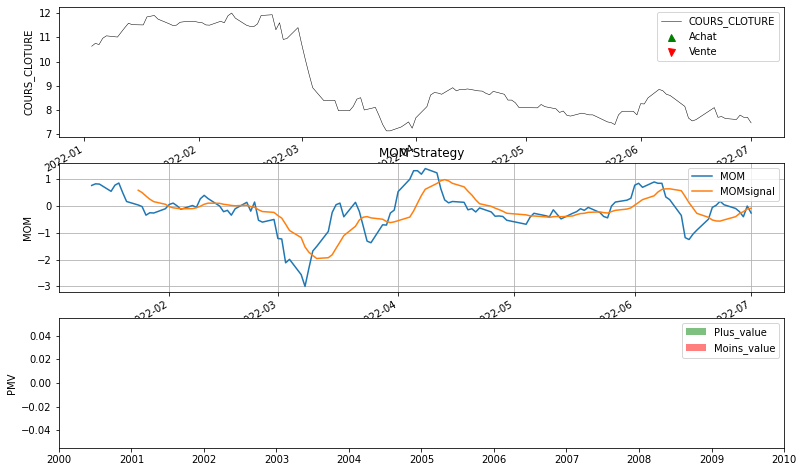

In [4]:
sign_momentum(df.Close,6,9)